## Important notes

As the code proposed in the book, to develop a model for semantic segmentation using the VOC2007 dataset, is not compatible with the current versions of the libraries, I will propose a new code to develop a model for semantic segmentation using the Oxford-IIT Pet Dataset.


In [1]:
!pip uninstall tensorflow

Found existing installation: tensorflow 2.17.1
Uninstalling tensorflow-2.17.1:
  Would remove:
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.11/dist-packages/tensorflow-2.17.1.dist-info/*
    /usr/local/lib/python3.11/dist-packages/tensorflow/*
Proceed (Y/n)? Y
  Successfully uninstalled tensorflow-2.17.1


In [2]:
!pip install -q tensorflow_datasets==4.8.0
!pip install -q -U tensorflow-text tensorflow==2.15
!pip install protobuf==3.20.*

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 56.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.3/475.3 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 100.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 83.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 59.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 117.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 79.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorstore 0.1.71 requires ml_dtypes>=0.

In [1]:
import numpy as np

import tensorflow as tf
print(tf.__version__)


2.15.0


In [2]:
import tensorflow_datasets as tfds
import math
import os

In [17]:
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [3]:
def downsample(depth):
    return tf.keras.Sequential(
        [
            tf.keras.layers.Conv2D(
                depth, 3, strides=2, padding="same", kernel_initializer="he_normal"
            ),
            tf.keras.layers.LeakyReLU(),
        ]
    )


def upsample(depth):
    return tf.keras.Sequential(
        [
            tf.keras.layers.Conv2DTranspose(
                depth, 3, strides=2, padding="same", kernel_initializer="he_normal"
            ),
            tf.keras.layers.ReLU(),
        ]
    )

In [4]:
def get_unet(input_size=(256, 256, 3), num_classes=21):

    # Downsample from 256x256 to 4x4, while adding depth
    # using powers of 2, startin from 2**5. Cap to 512.
    size=input_size[0]
    encoders = []
    for i in range(2, int(math.log2(size))):
        depth = 2 ** (i + 5)
        if depth > 512:
            depth = 512
        encoders.append(downsample(depth=depth))

    # Upsample from 4x4 to 256x256, reducing the depth
    decoders = []
    for i in reversed(range(2, int(math.log2(size)))):
        depth = 2 ** (i + 5)
        if depth < 32:
            depth = 32
        if depth > 512:
            depth = 512
        decoders.append(upsample(depth=depth))

    # Build the model by invoking the encoder layers with the correct input
    inputs = tf.keras.layers.Input(input_size)
    concat = tf.keras.layers.Concatenate()

    x = inputs
    # Encoder: downsample loop
    skips = []
    for conv in encoders:
        x = conv(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Decoder: input + skip connection
    for deconv, skip in zip(decoders, skips):
        x = deconv(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    # Add the last layer on top and define the model
    last = tf.keras.layers.Conv2DTranspose(
        num_classes, 3, strides=2, padding="same", kernel_initializer="he_normal"
    )

    outputs = last(x)
    return tf.keras.Model(inputs=inputs, outputs=outputs)


In [5]:
LUT = {
    (0, 0, 0): 0, # background
    (128, 0, 0): 1, # aeroplane
    (0, 128, 0): 2, # bicycle
    (128, 128, 0): 3, # bird
    (0, 0, 128): 4, # boat
    (128, 0, 128): 5, # bottle
    (0, 128, 128): 6, # bus
    (128, 128, 128): 7, # car
    (64, 0, 0): 8, # cat
    (192, 0, 0): 9, # chair
    (64, 128, 0): 10, # cow
    (192, 128, 0): 11, # diningtable
    (64, 0, 128): 12, # dog
    (192, 0, 128): 13, # horse
    (64, 128, 128): 14, # motorbike
    (192, 128, 128): 15, # person
    (0, 64, 0): 16, # pottedplant
    (128, 64, 0): 17, # sheep
    (0, 192, 0): 18, # sofa
    (128, 192, 0): 19, # train
    (0, 64, 128): 20, # tvmonitor
    (255, 255, 255): 21, # undefined / don't care
}


## Downloading the Oxford-IIIT Pets dataset

The dataset is available from TensorFlow Datasets. The segmentation masks are included in version 3+.

In [8]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

In addition, the image color values are normalized to the [0, 1] range. Finally, as mentioned above the pixels in the segmentation mask are labeled either {1, 2, 3}. For the sake of convenience, subtract 1 from the segmentation mask, resulting in labels that are : {0, 1, 2}.

In [9]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [10]:
def load_image(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(
    datapoint['segmentation_mask'],
    (128, 128),
    method = tf.image.ResizeMethod.NEAREST_NEIGHBOR,
  )

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

The dataset already contains the required training and test splits, so continue to use the same splits:

In [11]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [12]:
train_images = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

The following class performs a simple augmentation by randomly-flipping an image. Go to the Image augmentation tutorial to learn more.

In [13]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

Build the input pipeline, applying the augmentation after batching the inputs:

In [14]:
train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_images.batch(BATCH_SIZE)

Visualize an image example and its corresponding mask from the dataset:

In [15]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

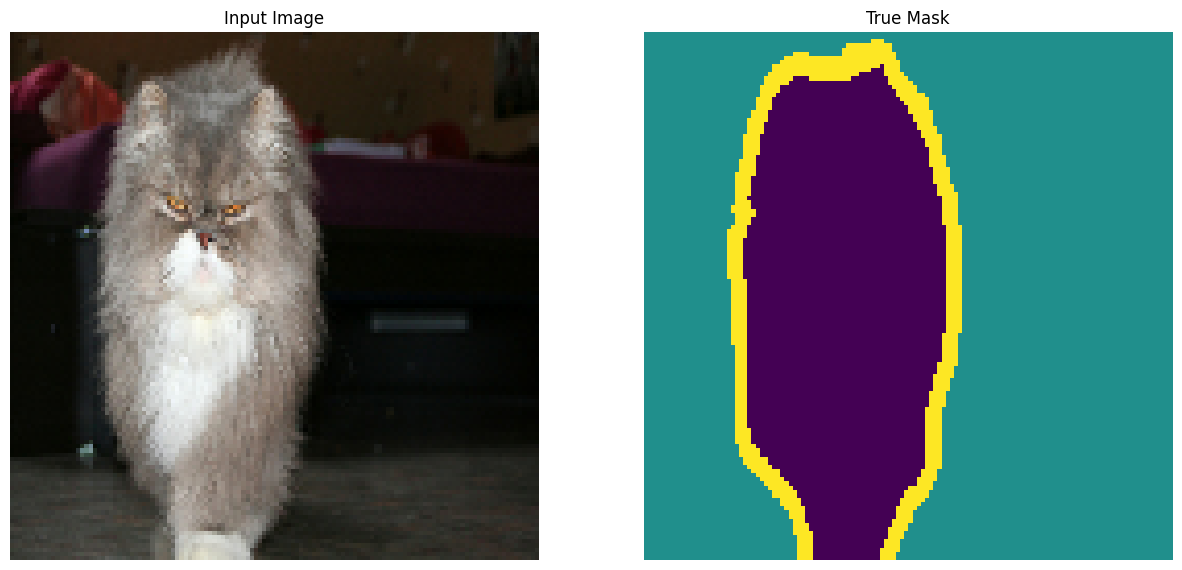

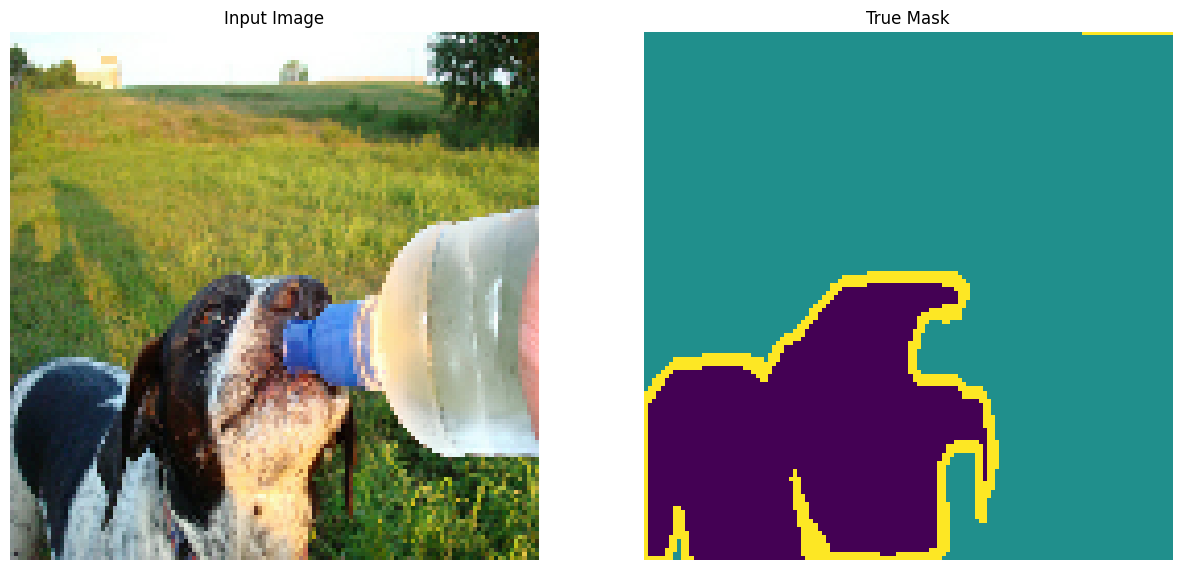

In [18]:
for images, masks in train_batches.take(2):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

In [19]:
OUTPUT_CLASSES = 3
model = get_unet(input_size=(128,128,3), num_classes=OUTPUT_CLASSES)

optimizer = tf.optimizers.Adam()

checkpoint_path = "ckpt/pb.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
tensorboard = tf.keras.callbacks.TensorBoard(write_images=True)
model.compile(optimizer=optimizer,
              #loss=lambda y_true, y_pred: tf.losses.SparseCategoricalCrossentropy(from_logits=True)(y_true, y_pred) + tf.losses.MeanAbsoluteError()(y_true, y_pred),
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])#, tf.metrics.MeanIoU(num_classes=21)])

Try out the model to check what it predicts before training:

In [20]:
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [21]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - 3s 3s/step


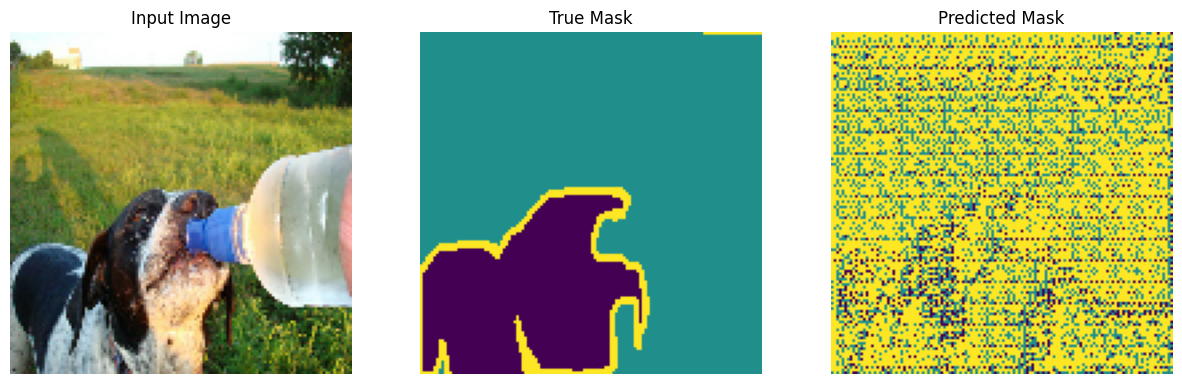

In [22]:
show_predictions()

In [23]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

1/1 [==============================] - 0s 18ms/step


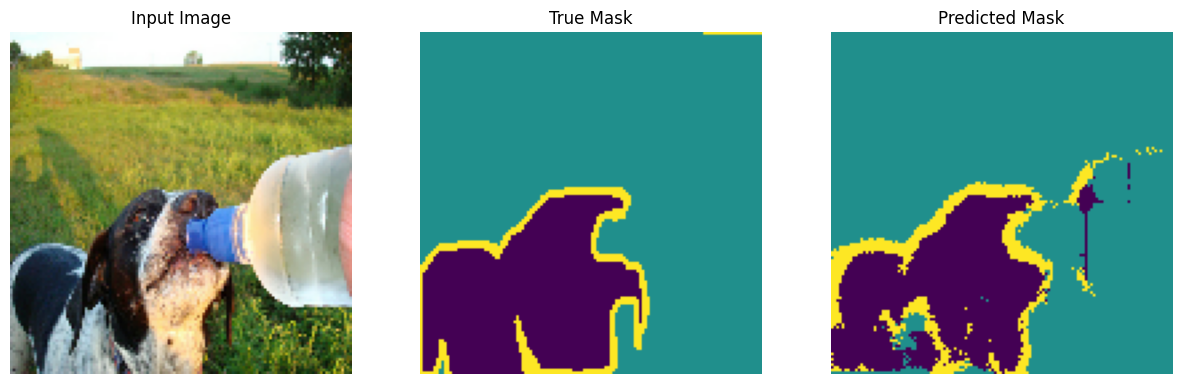


Sample Prediction after epoch 20

57/57 [==============================] - 35s 616ms/step - loss: 0.3055 - accuracy: 0.8803 - val_loss: 0.4493 - val_accuracy: 0.8356


In [24]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches,
                          callbacks=[DisplayCallback()])

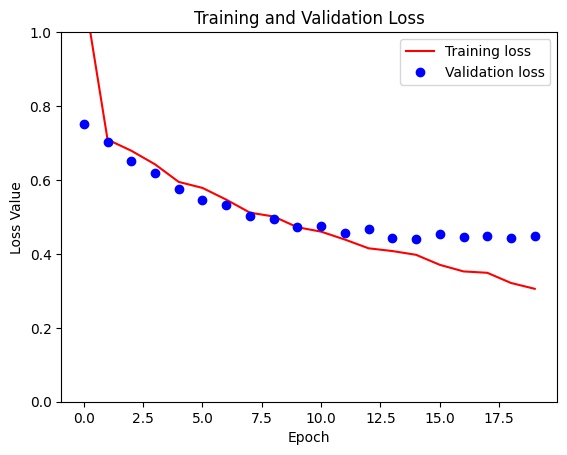

In [25]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

Now, make some predictions. In the interest of saving time, the number of epochs was kept small, but you may set this higher to achieve more accurate results.

2/2 [==============================] - 0s 151ms/step


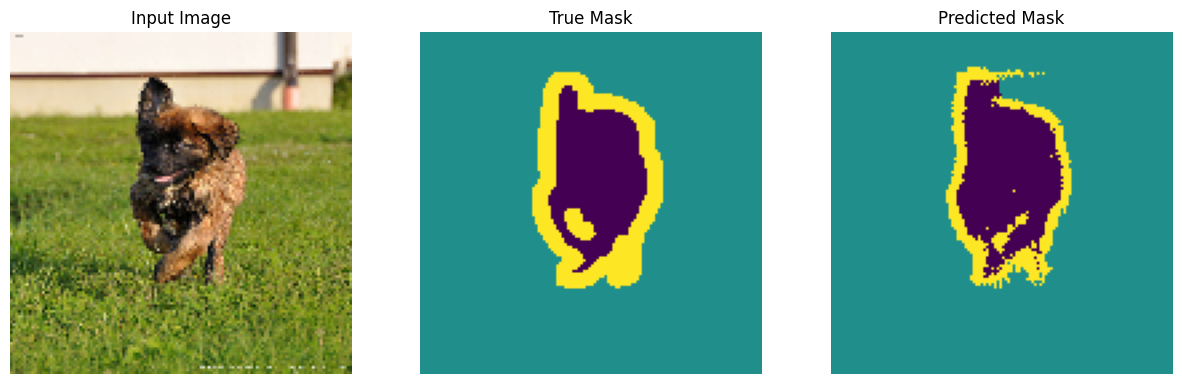

2/2 [==============================] - 0s 111ms/step


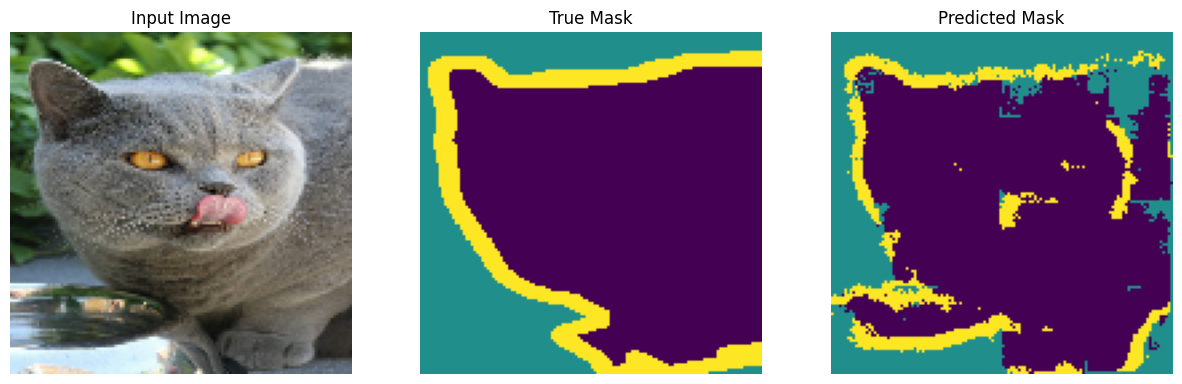

2/2 [==============================] - 0s 84ms/step


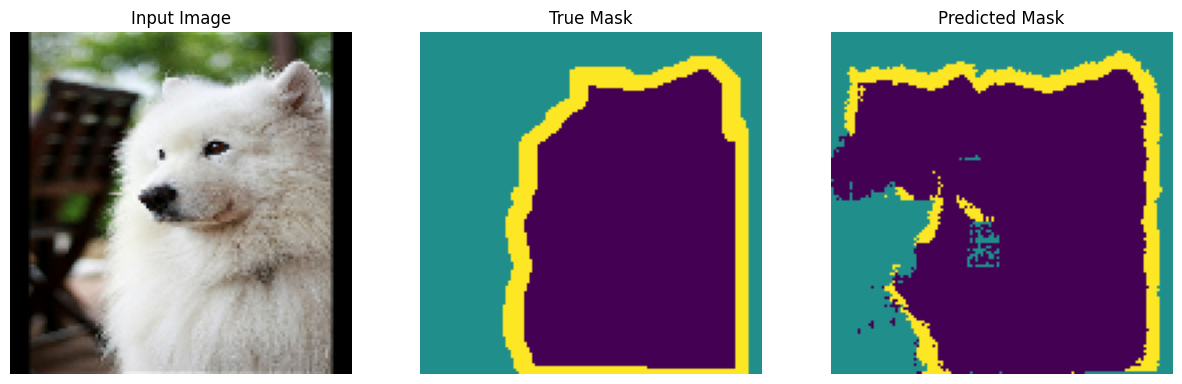

In [26]:
show_predictions(test_batches, 3)